In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
from sklearn.model_selection import train_test_split
from cvxopt import matrix as qpmatrix
from cvxopt import solvers as qpsolvers
from sklearn.svm import SVC

In [ ]:
data_ = pd.read_csv('/content/gdrive/My Drive/CS5691/assignment-2/datasets/Dataset_2_Team_33.csv')

In [ ]:
data_['Class_label'][data_['Class_label'] == 0] = -1
data_0 = data_[data_['Class_label'] == -1]
data_1 = data_[data_['Class_label'] == 1]

data_0 = data_0.values
data_1 = data_1.values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
data_train, data_test = train_test_split(data_, test_size = 0.25)

In [ ]:
data_train = data_train.values
data_test = data_test.values

In [ ]:
x_train = data_train[:, 0:2]
y_train = data_train[:, 2]

x_test = data_test[:, 0:2]
y_test = data_test[:, 2]

In [ ]:
y_train = y_train.reshape(-1, 1)

In [ ]:
m = x_train.shape[0]
print(x_train)

[[-1.01836325  0.23182039]
 [ 2.18169532  0.3881282 ]
 [ 1.49845775 -0.16005474]
 ...
 [ 0.5509483   0.46808011]
 [ 1.01117784  0.55948299]
 [ 0.88093739 -0.46004688]]


In [ ]:
# SECTION: SOFT MARGIN SVM IMPLEMENTATION FROM SCRATCH

In [ ]:
xy_prod = y_train * x_train
matP = np.dot(xy_prod, xy_prod.T)

matG = np.vstack((-1*np.eye(m), np.eye(m)))

C = 0.1 # 0.1 is the best value
matH = np.hstack((np.zeros(m), np.ones(m)*C))

In [ ]:
P = qpmatrix(matP)
q = qpmatrix(-np.ones((m, 1)))
G = qpmatrix(matG)
h = qpmatrix(matH)
A = qpmatrix(y_train.reshape(1, -1))
b = qpmatrix(np.zeros(1))

In [ ]:
solA = qpsolvers.qp(P, q, G, h, A, b)
alphas = np.array(solA['x'])

     pcost       dcost       gap    pres   dres
 0: -1.6211e+02 -1.5752e+02  5e+03  3e+01  7e-15
 1: -2.6229e+01 -1.4730e+02  3e+02  8e-01  6e-15
 2: -1.9716e+01 -5.4187e+01  3e+01  2e-16  1e-15
 3: -2.3406e+01 -2.9853e+01  6e+00  2e-16  1e-15
 4: -2.4950e+01 -2.7143e+01  2e+00  2e-16  1e-15
 5: -2.5445e+01 -2.6322e+01  9e-01  2e-16  1e-15
 6: -2.5644e+01 -2.6020e+01  4e-01  2e-16  1e-15
 7: -2.5734e+01 -2.5888e+01  2e-01  3e-16  1e-15
 8: -2.5776e+01 -2.5828e+01  5e-02  2e-16  1e-15
 9: -2.5794e+01 -2.5805e+01  1e-02  2e-16  1e-15
10: -2.5799e+01 -2.5801e+01  2e-03  2e-16  1e-15
11: -2.5800e+01 -2.5800e+01  3e-05  2e-16  1e-15
12: -2.5800e+01 -2.5800e+01  3e-07  4e-16  1e-15
Optimal solution found.


In [ ]:
valW = np.dot((y_train * alphas).T, x_train).reshape(1, -1)
suppVec = np.nonzero(alphas > 1e-4)[0]
print('# of support vectors:', len(suppVec))
valB= 0
for i in suppVec:
  valB += y_train[i] - np.dot(x_train[i], valW.T)
valB = valB / len(suppVec)
print('value of b:', valB)

marginCalc = y_train * (np.dot(x_train, valW.T) + np.array(valB[0]))
margins = np.nonzero(marginCalc == 1)[0]
print('# of SVs lying on margins:', len(margins))

# of support vectors: 286
value of b: [0.2103373]
# of SVs lying on margins: 0


In [ ]:
y_pred = np.dot(x_test, valW.T) + np.array(valB[0])

In [ ]:
y_pred_train = np.dot(x_train, valW.T) + np.array(valB[0])

In [ ]:
count_train = 0
decount_train = 0
for i in range(y_pred_train.shape[0]):
  if y_pred_train[i] <= 0:
    y_pred_train[i] = -1
  else:
    y_pred_train[i] = 1

  if y_pred_train[i] == y_train[i]:
    count_train += 1
  else:
    decount_train += 1
print(count_train, decount_train)
# print(y_pred_train, y_train)
print('Accuracy for train dataset:', count_train / y_pred_train.shape[0])
print('Incorrect for train dataset:', decount_train / y_pred_train.shape[0])

660 90
Accuracy for train dataset: 0.88
Incorrect for train dataset: 0.12


In [ ]:
count_test = 0
decount_test = 0
for i in range(y_pred.shape[0]):
  if y_pred[i] <= 0:
    y_pred[i] = -1
  else:
    y_pred[i] = 1

  if y_pred[i] == y_test[i]:
    count_test += 1
  else:
    decount_test += 1
print(count_test, decount_test)

print('Accuracy for train dataset:', count_test / y_pred.shape[0])
print('Incorrect for train dataset:', decount_test / y_pred.shape[0])

219 31
Accuracy for train dataset: 0.876
Incorrect for train dataset: 0.124


In [ ]:
ConMat1 = np.zeros((3,3))

In [ ]:
for i in range(y_pred.shape[0]):
  ConMat1[int(y_pred[i])+1, int(y_test[i])+1] += 1

In [ ]:
print('Confusion Matrix 1: \n', ConMat1)

Confusion Matrix 1: 
 [[119.   0.  18.]
 [  0.   0.   0.]
 [ 13.   0. 100.]]


In [ ]:
# SECTION: SOFT MARGIN SVM IMPLEMENTATION USING INBUILT FUNCTION

In [ ]:
clf1 = SVC(C=0.0001, kernel='linear')
clf1.fit(x_train, y_train.ravel())

SVC(C=0.0001, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
clf2 = SVC(C=0.0005, kernel='linear')
clf2.fit(x_train, y_train.ravel())

SVC(C=0.0005, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
clf3 = SVC(C=0.001, kernel='linear')
clf3.fit(x_train, y_train.ravel())

SVC(C=0.001, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
clf4 = SVC(C=0.005, kernel='linear')
clf4.fit(x_train, y_train.ravel())

SVC(C=0.005, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
clf5 = SVC(C=0.01, kernel='linear')
clf5.fit(x_train, y_train.ravel())

SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
clf6 = SVC(C=0.05, kernel='linear')
clf6.fit(x_train, y_train.ravel())

SVC(C=0.05, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
clf7 = SVC(C=0.1, kernel='linear')
clf7.fit(x_train, y_train.ravel())

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
clf8 = SVC(C=0.5, kernel='linear')
clf8.fit(x_train, y_train.ravel())

SVC(C=0.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
clf9 = SVC(C=1, kernel='linear')
clf9.fit(x_train, y_train.ravel())

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
print('with C = 0.0001: ', clf1.score(x_test, y_test))
print('with C = 0.0005: ', clf2.score(x_test, y_test))
print('with C = 0.001:  ', clf3.score(x_test, y_test))
print('with C = 0.005:  ', clf4.score(x_test, y_test))
print('with C = 0.01:   ', clf5.score(x_test, y_test))
print('with C = 0.05:   ', clf6.score(x_test, y_test))
print('with C = 0.1:    ', clf7.score(x_test, y_test))
print('with C = 0.5:    ', clf8.score(x_test, y_test))
print('with C = 1:      ', clf9.score(x_test, y_test))

with C = 0.0001:  0.472
with C = 0.0005:  0.472
with C = 0.001:   0.772
with C = 0.005:   0.84
with C = 0.01:    0.848
with C = 0.05:    0.876
with C = 0.1:     0.876
with C = 0.5:     0.876
with C = 1:       0.876


In [ ]:
clf7.support_vectors_.shape

(286, 2)

In [ ]:
clf7.intercept_

array([0.22235892])

In [ ]:
y_pred_final = clf7.predict(x_test)

In [ ]:
ConMat2 = np.zeros((3,3))

In [ ]:
for i in range(y_pred_final.shape[0]):
  ConMat2[int(y_pred_final[i])+1, int(y_test[i])+1] += 1

In [ ]:
print('Confusion Matrix 2: \n', ConMat2)

Confusion Matrix 2: 
 [[119.   0.  18.]
 [  0.   0.   0.]
 [ 13.   0. 100.]]


In [ ]:
# SECTION: PENALISE THE FALSE POSITIVE, k > 0

In [ ]:
for k_val in [2, 4, 8, 16]:
  clf = SVC(C = 0.1, kernel = 'linear', class_weight = {1:k_val})
  clf.fit(x_train, y_train.ravel())
  print('\n')
  print('Modified SVMs, k=' + str(k_val) + ', on train data:', clf.score(x_train, y_train))
  print('Modified SVMs, k=' + str(k_val) + ', on test data:', clf.score(x_test, y_test))



Modified SVMs, k=2, on train data: 0.868
Modified SVMs, k=2, on test data: 0.86


Modified SVMs, k=4, on train data: 0.828
Modified SVMs, k=4, on test data: 0.844


Modified SVMs, k=8, on train data: 0.7786666666666666
Modified SVMs, k=8, on test data: 0.788


Modified SVMs, k=16, on train data: 0.68
Modified SVMs, k=16, on test data: 0.704


In [ ]:
# SECTION: PLOTTING THE DECISION BOUNDARIES AND SUPPORT VECTORS

In [ ]:
X1 = np.linspace(-1.75, 2.75, 200)
X2 = np.linspace(-1.25, 1.75, 200)
X1, X2 = np.meshgrid(X1, X2)

In [ ]:
DecFunc = clf7.decision_function(np.c_[X1.ravel(), X2.ravel()])
DecFunc = DecFunc.reshape(X1.shape)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

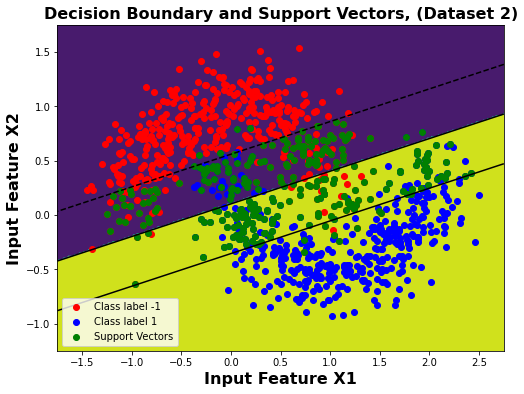

In [ ]:
plt.figure(1, figsize = [8, 6])
plt.contourf(X1, X2, DecFunc > 0)
plt.contour(X1, X2, DecFunc, levels = [-1, 0, 1], colors = 'k')
scatter_0 = plt.scatter(data_0[:, 0], data_0[:, 1], color = 'red', label = 'Class label -1')
scatter_1 = plt.scatter(data_1[:, 0], data_1[:, 1], color = 'blue', label = 'Class label 1')
scatter_2 = plt.scatter(clf7.support_vectors_[:, 0], clf7.support_vectors_[:, 1], color = 'green', marker = 'o', label = 'Support Vectors')
plt.xlabel('Input Feature X1', fontweight='bold', fontsize=16)
plt.ylabel('Input Feature X2', fontweight='bold', fontsize=16)
plt.legend(handles = [scatter_0, scatter_1, scatter_2], loc = 'lower left')
plt.title('Decision Boundary and Support Vectors, (Dataset 2)', fontweight='bold', fontsize=16)
plt.savefig("PartB_SVM.png")
files.download("PartB_SVM.png")
# plt.annotate('Support Vector', xy = (clf.support_vectors_[2,0], clf.support_vectors_[2, 1]), xytext = (3, 1.5), arrowprops = dict(facecolor = 'black', shrink = 0.05))